In [1]:
import numpy as np
import torch
import pandas as pd
from torch import nn
from torchvision import transforms
from PIL import Image
import numpy as np
import os, copy, json
import re, math, sys
import random
from tqdm import tqdm
from functools import partial

from collections import defaultdict

from transformers import CLIPProcessor, CLIPModel

import cv2

from matplotlib import pyplot as plt


### Load model

In [2]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [3]:
processor

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToke

### Load data

In [15]:
STIMULI_PATH = "../data_prep/jan8_preliminary_sampled_stimuli.pickle"
stimuli_df = pd.read_pickle(STIMULI_PATH)
stimuli_df

,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff,performance_group
468,../VALSE_data/images/coco2017/000000122672.jpg,A man is riding a surfboard through a wave.,A man is riding a surfboard against a wave.,relations,31.702688,32.111187,-0.408499,low_perf
274,../VALSE_data/images/coco2017/000000427649.jpg,The boat sits in the lake below the mountain.,The boat sits in the lake on the mountain.,relations,27.193933,27.211042,-0.017109,low_perf
243,../VALSE_data/images/coco2017/000000451150.jpg,Half a dozen donuts are sitting in a box.,Half a dozen donuts are sitting near a box.,relations,30.128731,30.556664,-0.427933,low_perf
376,../VALSE_data/images/coco2017/000000546659.jpg,A locomotive train carrying carts down a track.,A locomotive train carrying carts up a track.,relations,29.779469,29.801533,-0.022064,low_perf
520,../VALSE_data/images/coco2017/000000229858.jpg,An adult and baby moose step out of a busy thi...,An adult and baby moose step inside of a busy ...,relations,32.175686,33.472778,-1.297092,low_perf
...,...,...,...,...,...,...,...,...
1412,../VALSE_data/images/swig/packaging_189.jpg,A young buck packages up a broom.,A young buck heaves up a broom.,actions,27.694311,22.859179,4.835133,high_perf
1550,../VALSE_data/images/swig/chasing_258.jpg,A hunter chases after a American bison.,A hunter forags after a American bison.,actions,37.372082,35.013138,2.358944,high_perf
1783,../VALSE_data/images/swig/tugging_29.jpg,A person tugs a power cord.,A power cord tugs on a person.,actions,24.806143,22.592257,2.213886,high_perf
1206,../VALSE_data/images/swig/coaching_90.jpg,A woman coaches people.,A woman reads people.,actions,28.184359,18.201620,9.982738,high_perf


### Run data through CLIP in a "simple" way

In [8]:
results = defaultdict(list)

for _, row in tqdm(stimuli_df.head(5).iterrows()):

    # copy over those things that should be copied directly
    for name in ["img_path", "caption", "foil", "linguistic_phenomena"]:
        results[name].append(row[name])

    # prepare data point as inputs to test model on
    image = Image.open(row["img_path"])

    test_sentences = [row["caption"],
                      row["foil"]]
    
    # create CLIP input with BOTH captions
    try:
        inputs = processor(
            text = test_sentences,
            images = image,
            return_tensors = 'pt',
            padding = True
        )

    except:
        print(f"Trouble processing {row['img_path']}")
        continue
    
    clip_logits = model(**inputs).logits_per_image[0,0:2].tolist()
    clip_cap_foil_diff = clip_logits[0] - clip_logits[1]

    # save relevant fields to the dictionary to either {caption} or {foil} (based on which it is)
    results["clip_pred_caption"].append(clip_logits[0]) # logit
    results["clip_pred_foil"].append(clip_logits[1])
    results["clip_pred_diff"].append(clip_cap_foil_diff)
    
out_df = pd.DataFrame.from_dict(results)
out_df

5it [00:00,  9.37it/s]


,img_path,caption,foil,linguistic_phenomena,clip_pred_caption,clip_pred_foil,clip_pred_diff
0,../VALSE_data/images/coco2017/000000122672.jpg,A man is riding a surfboard through a wave.,A man is riding a surfboard against a wave.,relations,31.702688,32.111187,-0.408499
1,../VALSE_data/images/coco2017/000000427649.jpg,The boat sits in the lake below the mountain.,The boat sits in the lake on the mountain.,relations,27.193933,27.211042,-0.017109
2,../VALSE_data/images/coco2017/000000451150.jpg,Half a dozen donuts are sitting in a box.,Half a dozen donuts are sitting near a box.,relations,30.128731,30.556664,-0.427933
3,../VALSE_data/images/coco2017/000000546659.jpg,A locomotive train carrying carts down a track.,A locomotive train carrying carts up a track.,relations,29.779469,29.801533,-0.022064
4,../VALSE_data/images/coco2017/000000229858.jpg,An adult and baby moose step out of a busy thi...,An adult and baby moose step inside of a busy ...,relations,32.175686,33.472778,-1.297092


5

## Build SHAP pipeline

### Masking functions

In [121]:
def vector_to_masked_images(masking_matrixes, original_image, blurred_image, N_ROWS):
    """Apply masking matrix to image
    masking_matrix should be N_ROWS, N_ROWS
    
    original_image should be 224 x 224 x 3
    
    value of 1 -> that patch is kept
    value of 0 -> that patch is blurred"""

    results = []

    patch_size = 224 // N_ROWS

    for masking_matrix in masking_matrixes:

        result = copy.deepcopy(original_image)

        for row in range(N_ROWS):
            for col in range(N_ROWS):
                #  boundaries of the current patch
                start_row, start_col = row * patch_size, col * patch_size
                end_row, end_col = start_row + patch_size, start_col + patch_size
                
                # If the mask value is 0, apply the blurred value
                if masking_matrix[row, col] == 0:
                    result[start_row:end_row, start_col:end_col] = \
                        blurred_image[start_row:end_row, start_col:end_col]

        results.append(result)
    
    return results

def blur_image(image, blur_value = 200):
    """Blurs numpy image"""
    blur_value = int(blur_value // 2) * 2 + 1
    blurred_image = cv2.GaussianBlur(image, (blur_value, blur_value), 0)
    return blurred_image
    


### Test masking

In [99]:
# image = Image.open("../VALSE_data/images/coco2017/000000122672.jpg")
# image = np.array(image.resize((224,224)))

# blurred_image = blur_image(image)

# test_mask_array = np.array([
#     [1, 0, 0, 1],
#     [0, 1, 1, 0],
#     [0, 0, 0, 0],
#     [0, 0, 0, 0]
# ])

# masked_img = vector_to_masked_images([test_mask_array], image, blurred_image)[0]
# plt.imshow(masked_img)

IndexError: index 4 is out of bounds for axis 1 with size 4

### Prediction function on a set of images

In [120]:
text_out = []

def model_predict(images, caption, foil):
    """Needs CAPTION and FOIL to be defined outside the function,
    they are kept constant within the function
    
    In practice SHAP will pass a SINGLE image in this step, so images = [image]"""

    processed = processor(text = [caption, foil],
                          images = images,
                          return_tensors = 'pt',
                          padding = True
                          )
    
    text_out.append(f"Processing SHAP with {caption} and {foil}")
    
    with torch.no_grad():
        outputs = model(**processed).logits_per_image # generatre logits for caption and foil for each image
        # Assuming the first score is for caption and second for foil
        score_diff = outputs[:, 0] - outputs[:, 1]  
    return score_diff.numpy() # this generates a caption-foil difference for each image in images


### SHAP function

In [204]:
import shap


N_ROWS = 4

background_mask = np.zeros((N_ROWS, N_ROWS))

masker = shap.maskers.Image(np.array([background_mask]))

def generate_shap(img_path, caption, foil, verbose = False, plots = True, export_plots = False):
    """Generate SHAP given a row of dataframe"""

    image = Image.open(img_path).convert('RGB') # open image and convert to THREE CHANNEL (SHAP needs a 224, 224, 3 image even if it's black and white)
    image = np.array(image.resize((224,224)))
    blurred_image = blur_image(image) # this is the background. blurred version

    if verbose: print("Image shape ", image.shape)

    def local_predict(masking_matrixes):
        """Given images=[image], make prediction involving image and caption and foil"""


        # take masked_matrixes and turn it into a list of masked images. Masked means substituting the blurred background
        images = vector_to_masked_images(masking_matrixes, # this variablew varies per shap masking instance
                                         image, blurred_image,  # these two are fixed per image
                                         N_ROWS)
        
        if verbose:
            print(masking_matrixes)
            for img in images:
                plt.imshow(img)
                plt.show()
        
        return model_predict(images, caption, foil)

    # create SHAP explainer
    # masker = shap.maskers.Image("inpaint_telea", (224, 224, 3))
    explainer = shap.Explainer(local_predict, masker, 
                               seed = 42)

    # get SHAP values
    starting_matrix = np.array([np.arange(1, N_ROWS**2+1).reshape(N_ROWS, N_ROWS)])
    if verbose: print("SHAP matrix shape", starting_matrix.shape)
    shap_values = explainer(starting_matrix, max_evals=10000, batch_size=250,)


    if plots or export_plots: 
        plt.figure()
        shap.plots.image(shap_values=shap_values.values[0][..., np.newaxis],
                        pixel_values=image, show = False)

        # Add the caption
        plt.figtext(0.5, 0.02, f"Caption: {caption}, \nFoil: {foil}", wrap=True, horizontalalignment='center', fontsize=7)

        # Save the plot as a PNG file
        if export_plots: plt.savefig(f"shap_output_imgs/{os.path.basename(img_path)}_CLIP_SHAP.png", bbox_inches='tight', pad_inches=0.5)
        if plots: plt.show()
        plt.close()
    

    return shap_values.values[0]



# Export SHAP maps

In [206]:

VERBOSE = False
DISPLAY_PLOTS = False
EXPORT_PLOTS = True

output = defaultdict(list)

for _, row in tqdm(stimuli_df.iterrows()):

    # copy main characteristics
    for name in ["img_path", "caption", "foil", "linguistic_phenomena"]:
        output[name].append(row[name])

    # calcualte shap map
    try:
        output["clip_shap_map"].append(generate_shap(row['img_path'], row['caption'], row['foil'],
                                    verbose = VERBOSE,
                                    plots = DISPLAY_PLOTS,
                                    export_plots = EXPORT_PLOTS)
                                    )
    except:
        output['clip_shap_map'].append("Error")
    
final_clip_shap_df = pd.DataFrame.from_dict(output)
    

0it [00:00, ?it/s]

(224, 224, 3)
(1, 4, 4)


1it [00:02,  3.00s/it]

(224, 224, 3)
(1, 4, 4)


2it [00:05,  2.96s/it]

(224, 224, 3)
(1, 4, 4)


3it [00:08,  2.98s/it]

(224, 224, 3)
(1, 4, 4)


4it [00:11,  2.97s/it]

(224, 224, 3)
(1, 4, 4)


5it [00:14,  2.98s/it]

(224, 224, 3)
(1, 4, 4)


6it [00:17,  3.01s/it]

(224, 224, 3)
(1, 4, 4)


7it [00:20,  3.01s/it]

(224, 224, 3)
(1, 4, 4)


8it [00:24,  3.02s/it]

(224, 224, 3)
(1, 4, 4)


9it [00:26,  2.99s/it]

(224, 224, 3)
(1, 4, 4)


10it [00:29,  2.96s/it]

(224, 224, 3)
(1, 4, 4)


11it [00:32,  2.95s/it]

(224, 224, 3)
(1, 4, 4)


12it [00:35,  2.98s/it]

(224, 224, 3)
(1, 4, 4)


13it [00:38,  2.98s/it]

(224, 224, 3)
(1, 4, 4)


14it [00:41,  2.97s/it]

(224, 224, 3)
(1, 4, 4)


15it [00:44,  2.99s/it]

(224, 224, 3)
(1, 4, 4)


16it [00:47,  3.00s/it]

(224, 224, 3)
(1, 4, 4)


17it [00:50,  3.01s/it]

(224, 224, 3)
(1, 4, 4)


18it [00:53,  3.00s/it]

(224, 224, 3)
(1, 4, 4)


19it [00:56,  3.00s/it]

(224, 224, 3)
(1, 4, 4)


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
20it [00:59,  3.01s/it]

(224, 224, 3)
(1, 4, 4)


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
21it [01:02,  3.01s/it]

(224, 224, 3)
(1, 4, 4)


22it [01:05,  3.04s/it]

(224, 224, 3)
(1, 4, 4)


23it [01:09,  3.05s/it]

(224, 224, 3)
(1, 4, 4)


24it [01:11,  3.03s/it]

(224, 224, 3)
(1, 4, 4)


25it [01:15,  3.13s/it]

(224, 224, 3)
(1, 4, 4)


26it [01:18,  3.03s/it]

(224, 224, 3)
(1, 4, 4)


27it [01:20,  2.97s/it]

(224, 224, 3)
(1, 4, 4)


28it [01:23,  2.94s/it]

(224, 224, 3)
(1, 4, 4)


29it [01:26,  2.91s/it]

(224, 224, 3)
(1, 4, 4)


30it [01:29,  2.95s/it]

(224, 224, 3)
(1, 4, 4)


31it [01:32,  2.95s/it]

(224, 224, 3)
(1, 4, 4)


32it [01:35,  2.96s/it]

(224, 224, 3)
(1, 4, 4)


33it [01:38,  2.94s/it]

(224, 224, 3)
(1, 4, 4)


34it [01:41,  2.94s/it]

(224, 224, 3)
(1, 4, 4)


35it [01:44,  2.91s/it]

(224, 224, 3)
(1, 4, 4)


36it [01:47,  2.89s/it]

(224, 224, 3)
(1, 4, 4)


37it [01:50,  2.89s/it]

(224, 224, 3)
(1, 4, 4)


38it [01:53,  2.91s/it]

(224, 224, 3)
(1, 4, 4)


39it [01:56,  2.96s/it]

(224, 224, 3)
(1, 4, 4)


40it [01:59,  3.02s/it]

(224, 224, 3)
(1, 4, 4)


41it [02:02,  3.06s/it]

(224, 224, 3)
(1, 4, 4)


42it [02:05,  3.03s/it]

(224, 224, 3)
(1, 4, 4)


43it [02:08,  3.01s/it]

(224, 224, 3)
(1, 4, 4)


44it [02:11,  3.02s/it]

(224, 224, 3)
(1, 4, 4)


45it [02:14,  3.01s/it]

(224, 224, 3)
(1, 4, 4)


46it [02:17,  3.00s/it]

(224, 224, 3)
(1, 4, 4)


47it [02:20,  2.96s/it]

(224, 224, 3)
(1, 4, 4)


48it [02:23,  2.97s/it]

(224, 224, 3)
(1, 4, 4)


49it [02:26,  2.98s/it]

(224, 224, 3)
(1, 4, 4)


50it [02:29,  2.94s/it]

(224, 224, 3)
(1, 4, 4)


51it [02:31,  2.89s/it]

(224, 224, 3)
(1, 4, 4)


52it [02:34,  2.88s/it]

(224, 224, 3)
(1, 4, 4)


53it [02:37,  2.87s/it]

(224, 224, 3)
(1, 4, 4)


54it [02:40,  2.86s/it]

(224, 224, 3)
(1, 4, 4)


55it [02:43,  2.88s/it]

(224, 224, 3)
(1, 4, 4)


56it [02:46,  2.93s/it]

(224, 224, 3)
(1, 4, 4)


57it [02:49,  3.01s/it]

(224, 224, 3)
(1, 4, 4)


58it [02:52,  3.06s/it]

(224, 224, 3)
(1, 4, 4)


59it [02:55,  3.06s/it]

(224, 224, 3)
(1, 4, 4)


60it [02:58,  3.09s/it]

(224, 224, 3)
(1, 4, 4)


61it [03:01,  3.02s/it]

(224, 224, 3)
(1, 4, 4)


62it [03:04,  2.99s/it]

(224, 224, 3)
(1, 4, 4)


63it [03:07,  2.93s/it]

(224, 224, 3)
(1, 4, 4)


64it [03:10,  2.88s/it]

(224, 224, 3)
(1, 4, 4)


65it [03:13,  2.85s/it]

(224, 224, 3)
(1, 4, 4)


66it [03:15,  2.86s/it]

(224, 224, 3)
(1, 4, 4)


67it [03:18,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


68it [03:21,  2.84s/it]

(224, 224, 3)
(1, 4, 4)


69it [03:24,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


70it [03:27,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


71it [03:30,  2.85s/it]

(224, 224, 3)
(1, 4, 4)


72it [03:33,  2.91s/it]

(224, 224, 3)
(1, 4, 4)


73it [03:35,  2.89s/it]

(224, 224, 3)
(1, 4, 4)


74it [03:38,  2.86s/it]

(224, 224, 3)
(1, 4, 4)


75it [03:41,  2.85s/it]

(224, 224, 3)
(1, 4, 4)


76it [03:44,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


77it [03:47,  2.81s/it]

(224, 224, 3)
(1, 4, 4)


78it [03:49,  2.80s/it]

(224, 224, 3)
(1, 4, 4)


79it [03:52,  2.79s/it]

(224, 224, 3)
(1, 4, 4)


80it [03:55,  2.78s/it]

(224, 224, 3)
(1, 4, 4)


81it [03:58,  2.79s/it]

(224, 224)
(1, 4, 4)
(224, 224, 3)
(1, 4, 4)


83it [04:01,  2.15s/it]

(224, 224, 3)
(1, 4, 4)


84it [04:03,  2.33s/it]

(224, 224, 3)
(1, 4, 4)


85it [04:06,  2.47s/it]

(224, 224, 3)
(1, 4, 4)


86it [04:09,  2.57s/it]

(224, 224, 3)
(1, 4, 4)


87it [04:12,  2.65s/it]

(224, 224, 3)
(1, 4, 4)


88it [04:15,  2.70s/it]

(224, 224, 3)
(1, 4, 4)


89it [04:18,  2.73s/it]

(224, 224, 3)
(1, 4, 4)


90it [04:20,  2.75s/it]

(224, 224, 3)
(1, 4, 4)


91it [04:23,  2.78s/it]

(224, 224, 3)
(1, 4, 4)


92it [04:26,  2.78s/it]

(224, 224, 3)
(1, 4, 4)


93it [04:29,  2.79s/it]

(224, 224, 3)
(1, 4, 4)


94it [04:32,  2.81s/it]

(224, 224, 3)
(1, 4, 4)


95it [04:35,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


96it [04:38,  2.87s/it]

(224, 224, 3)
(1, 4, 4)


97it [04:40,  2.84s/it]

(224, 224, 3)
(1, 4, 4)


98it [04:43,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


99it [04:46,  2.80s/it]

(224, 224, 3)
(1, 4, 4)


100it [04:49,  2.79s/it]

(224, 224, 3)
(1, 4, 4)


101it [04:51,  2.79s/it]

(224, 224, 3)
(1, 4, 4)


102it [04:54,  2.81s/it]

(224, 224, 3)
(1, 4, 4)


103it [04:57,  2.85s/it]

(224, 224, 3)
(1, 4, 4)


104it [05:00,  2.86s/it]

(224, 224, 3)
(1, 4, 4)


105it [05:03,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


106it [05:06,  2.82s/it]

(224, 224, 3)
(1, 4, 4)


107it [05:08,  2.81s/it]

(224, 224, 3)
(1, 4, 4)


108it [05:11,  2.81s/it]

(224, 224, 3)
(1, 4, 4)


109it [05:14,  2.81s/it]

(224, 224, 3)
(1, 4, 4)


110it [05:17,  2.81s/it]

(224, 224, 3)
(1, 4, 4)


111it [05:20,  2.80s/it]

(224, 224, 3)
(1, 4, 4)


112it [05:23,  2.84s/it]

(224, 224, 3)
(1, 4, 4)


113it [05:25,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


114it [05:28,  2.82s/it]

(224, 224, 3)
(1, 4, 4)


115it [05:31,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


116it [05:34,  2.85s/it]

(224, 224, 3)
(1, 4, 4)


117it [05:37,  2.87s/it]

(224, 224, 3)
(1, 4, 4)


118it [05:40,  2.85s/it]

(224, 224, 3)
(1, 4, 4)


119it [05:43,  2.85s/it]

(224, 224, 3)
(1, 4, 4)


120it [05:45,  2.85s/it]

(224, 224, 3)
(1, 4, 4)


121it [05:48,  2.86s/it]

(224, 224, 3)
(1, 4, 4)


122it [05:51,  2.85s/it]

(224, 224, 3)
(1, 4, 4)


123it [05:54,  2.84s/it]

(224, 224, 3)
(1, 4, 4)


124it [05:57,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


125it [06:00,  2.86s/it]

(224, 224, 3)
(1, 4, 4)


126it [06:03,  2.92s/it]

(224, 224, 3)
(1, 4, 4)


127it [06:06,  2.91s/it]

(224, 224, 3)
(1, 4, 4)


128it [06:08,  2.88s/it]

(224, 224, 3)
(1, 4, 4)


129it [06:11,  2.85s/it]

(224, 224, 3)
(1, 4, 4)


130it [06:14,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


131it [06:17,  2.82s/it]

(224, 224, 3)
(1, 4, 4)


132it [06:20,  2.82s/it]

(224, 224, 3)
(1, 4, 4)


133it [06:22,  2.81s/it]

(224, 224, 3)
(1, 4, 4)


134it [06:25,  2.80s/it]

(224, 224, 3)
(1, 4, 4)


135it [06:28,  2.80s/it]

(224, 224, 3)
(1, 4, 4)


136it [06:31,  2.79s/it]

(224, 224, 3)
(1, 4, 4)


137it [06:33,  2.78s/it]

(224, 224, 3)
(1, 4, 4)


138it [06:36,  2.79s/it]

(224, 224, 3)
(1, 4, 4)


139it [06:39,  2.79s/it]

(224, 224, 3)
(1, 4, 4)


140it [06:42,  2.79s/it]

(224, 224, 3)
(1, 4, 4)


141it [06:45,  2.78s/it]

(224, 224, 3)
(1, 4, 4)


142it [06:47,  2.77s/it]

(224, 224, 3)
(1, 4, 4)


143it [06:50,  2.78s/it]

(224, 224, 3)
(1, 4, 4)


144it [06:53,  2.78s/it]

(224, 224, 3)
(1, 4, 4)


145it [06:56,  2.87s/it]

(224, 224, 3)
(1, 4, 4)


146it [06:59,  2.84s/it]

(224, 224, 3)
(1, 4, 4)


147it [07:02,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


148it [07:04,  2.83s/it]

(224, 224, 3)
(1, 4, 4)


149it [07:07,  2.82s/it]

(224, 224, 3)
(1, 4, 4)


150it [07:10,  2.84s/it]

(224, 224, 3)
(1, 4, 4)


151it [07:13,  2.86s/it]

(224, 224, 3)
(1, 4, 4)


152it [07:16,  2.86s/it]

(224, 224, 3)
(1, 4, 4)


153it [07:19,  2.87s/it]

(224, 224, 3)
(1, 4, 4)


154it [07:22,  2.89s/it]

(224, 224, 3)
(1, 4, 4)


155it [07:25,  2.90s/it]

(224, 224, 3)
(1, 4, 4)


156it [07:28,  2.91s/it]

(224, 224, 3)
(1, 4, 4)


157it [07:30,  2.91s/it]

(224, 224, 3)
(1, 4, 4)


158it [07:33,  2.93s/it]

(224, 224, 3)
(1, 4, 4)


159it [07:36,  2.93s/it]

(224, 224, 3)
(1, 4, 4)


160it [07:39,  2.93s/it]

(224, 224, 3)
(1, 4, 4)


161it [07:42,  2.92s/it]

(224, 224, 3)
(1, 4, 4)


162it [07:45,  2.91s/it]

(224, 224, 3)
(1, 4, 4)


163it [07:48,  2.89s/it]

(224, 224, 3)
(1, 4, 4)


164it [07:51,  2.88s/it]

(224, 224, 3)
(1, 4, 4)


165it [07:54,  2.90s/it]

(224, 224, 3)
(1, 4, 4)


166it [07:57,  2.90s/it]

(224, 224, 3)
(1, 4, 4)


167it [08:00,  2.92s/it]

(224, 224, 3)
(1, 4, 4)


168it [08:02,  2.89s/it]

(224, 224, 3)
(1, 4, 4)


169it [08:05,  2.89s/it]

(224, 224, 3)
(1, 4, 4)


170it [08:08,  2.88s/it]

(224, 224, 3)
(1, 4, 4)


171it [08:11,  2.85s/it]

(224, 224, 3)
(1, 4, 4)


172it [08:14,  2.84s/it]

(224, 224, 3)
(1, 4, 4)


173it [08:17,  2.85s/it]

(224, 224, 3)
(1, 4, 4)


174it [08:19,  2.84s/it]

(224, 224, 3)
(1, 4, 4)


175it [08:22,  2.87s/it]

(224, 224, 3)
(1, 4, 4)


176it [08:25,  2.88s/it]

(224, 224, 3)
(1, 4, 4)


177it [08:28,  2.88s/it]

(224, 224, 3)
(1, 4, 4)


178it [08:31,  2.89s/it]

(224, 224, 3)
(1, 4, 4)


179it [08:34,  2.87s/it]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [207]:
#final_clip_shap_df.to_pickle("shap_output_data/clip_jan12.pickle")

In [200]:
new_df

,img_path,caption,foil,linguistic_phenomena,clip_shap_map
0,../VALSE_data/images/coco2017/000000122672.jpg,A man is riding a surfboard through a wave.,A man is riding a surfboard against a wave.,relations,"[[0.06365090608596802, -0.007333993911743164, ..."
1,../VALSE_data/images/coco2017/000000427649.jpg,The boat sits in the lake below the mountain.,The boat sits in the lake on the mountain.,relations,"[[0.004752039909362793, 0.015845835208892822, ..."


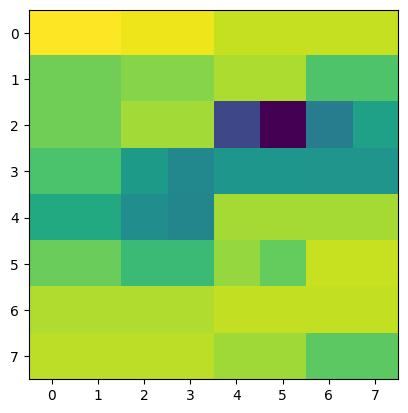

In [189]:
plt.imshow(final_clip_shap_df['clip_shap_map'][0])